In [1]:
%load_ext autoreload
%autoreload 2
from __future__ import print_function
import numpy as np
from keras.models import Model, Sequential
from keras.layers import Input, LSTM, Dense, Lambda, Activation, dot, concatenate, TimeDistributed
from keras import backend as K
import seaborn as sns
%matplotlib inline 
# https://github.com/keras-team/keras/blob/master/examples/lstm_seq2seq.py
from script.seq2seq import generateInOut

Using TensorFlow backend.


# Simple character level Seq2Seq Translation

## Preparation
- Bidirectional LSTM
    * Allow information from future inputs
    * LSTM only allows past information
<img src="https://cdn-images-1.medium.com/max/764/1*6QnPUSv_t9BY9Fv8_aLb-Q.png" width="500">


    


- RNN in Keras
https://keras.io/layers/recurrent/

    * keras.layers.RNN(cell, return_sequences=False, return_state=False, go_backwards=False, stateful=False, unroll=False)
    * keras.layers.LSTM(units, activation='tanh', recurrent_activation='hard_sigmoid', use_bias=True, kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal', bias_initializer='zeros', unit_forget_bias=True, kernel_regularizer=None, recurrent_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, recurrent_constraint=None, bias_constraint=None, dropout=0.0, recurrent_dropout=0.0, implementation=1, return_sequences=False, return_state=False, go_backwards=False, stateful=False, unroll=False)
    * 3D tensor with shape (batch_size, timesteps, input_dim).



## Import Data

Reference:

https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html



In [2]:
encoder_input_data,\
decoder_input_data,\
decoder_target_data,\
num_samples, \
input_vocabulary, \
output_vocabulary, \
input_sequence_length, \
output_sequence_length, \
input_token_index, \
target_token_index = \
generateInOut(data_path = './data/fra.txt', num_samples = 10000)

Number of samples: 10000
Number of unique input tokens: 71
Number of unique output tokens: 94
Max sequence length for inputs: 16
Max sequence length for outputs: 59


In [3]:
encoder_input_data.shape # num_sample, input_sequence_length, input_vocabulary

(10000, 16, 71)

In [4]:
decoder_input_data.shape # num_sample, output_seq_length, output_vocabulary

(10000, 59, 94)

In [5]:
decoder_target_data.shape # num_sample, output_seq_length, output_vocabulary

(10000, 59, 94)

In [44]:
re_target_token_index = {}
for key, value in target_token_index.items():
    re_target_token_index[value] = key
re_target_token_index[0], re_target_token_index[1]

('\t', '\n')

## Model Definition


- Encoder: 1-direction LSTM
- Decoder: 1-direction LSTM
- Embedding: None

### Model Params

In [10]:
epochs = 100
batch_size = 64
lstm_units = 256

### Encoder Network

Note, if use word instead of character:
https://keras.io/layers/embeddings/

In [11]:
# Define Encoder Input
encoder_inputs = Input(shape=(input_sequence_length, input_vocabulary)) # or (None, input_vocabulary)

# Define Encoder Layer itself
encoder = LSTM(lstm_units, return_state=True)

# Define Encoder Output: Output, hidden state 'h' and 'c'
e_all_h,e_last_h,e_last_c = encoder(encoder_inputs)

# For Encoder, Output is not used
encoder_states = [e_last_h, e_last_c]

### Decoder Network (V1) - Teacher Forcing

In [12]:
# Define Decoder Input
decoder_inputs = Input(shape=(output_sequence_length, output_vocabulary))

# Define Decoder Layer itself, note the difference with encoder
decoder_lstm = LSTM(lstm_units, return_sequences=True, return_state=True)

# Extract Output, note the differene: 
# initial state is given from encoder, instead of default (Zero??)
d_all_h,d_last_h,d_last_c = decoder_lstm(decoder_inputs,
                                     initial_state = encoder_states)

decoder_dense = Dense(output_vocabulary, activation='softmax')
decoder_outputs = decoder_dense(d_all_h)

### Decoder Network (V2) - Sampling

In [ ]:
# Note, sequence length is "ONE"
decoder_inputs = Input(shape=(1, output_vocabulary))

# Same Decoder
decoder_lstm = LSTM(lstm_units, return_sequences=True, return_state=True)

# Same Dense Layer
decoder_dense = Dense(output_vocabulary, activation='softmax')

# Define some lists
final_outputs = []
previous_states = encoder_states # States from encoder
current_inputs = decoder_inputs # Start sentence index

# Generate States, Outputs one-by-one
for _ in range(output_sequence_length):
    
    d_all_h, d_last_h, d_last_c = decoder_lstm(current_inputs, initial_state = previous_states)
    densed_output = decoder_dense(d_all_h) 
    final_outputs.append(densed_output)
    
    current_inputs = densed_output
    previous_states = [d_last_h, d_last_c]

# Concatenate all predictions
decoder_outputs = Lambda(lambda x: K.concatenate(x, axis=1))(final_outputs)

In [ ]:
# Start of Sentence one-hot encoding
target_token_index['\t']

In [ ]:
# OVERWRITE decoder_input_data to be "START" character
decoder_input_data = np.zeros(shape = (num_samples, 1, output_vocabulary))
decoder_input_data[:, 0, target_token_index['\t']] = 1.
decoder_input_data.shape  # num_sample, output_seq_length = 1, output_vocabulary

## Model Training

In [ ]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size = batch_size,
          epochs = epochs,
          validation_split = 0.2)

## Model Prediction

In [ ]:
# Note, only apply to 2nd type of training method (using sampling)
probs = model.predict([encoder_input_data[:5,:,:], decoder_input_data[:5,:,:]])
predictions = np.argmax(probs, axis = 1)
predictions[0]

# Attention Mechanism with Simple example

Then use reverse index to generate actual sentence until first "end of sentence" character

Reference:
- https://medium.com/datalogue/attention-in-keras-1892773a4f22
- https://github.com/datalogue/keras-attention/blob/master/models/custom_recurrents.py
- https://guillaumegenthial.github.io/sequence-to-sequence.html
- https://github.com/wanasit/katakana/blob/master/notebooks/Attention-based%20Sequence-to-Sequence%20in%20Keras.ipynb

## Generate simple test case to show attention

In [98]:
import string
import random

In [99]:
random.choice(string.ascii_letters)
num_samples = 10000
input_vocabulary = 52 
output_vocabulary = 52 + 2
input_sequence_length = 10
output_sequence_length = 10 + 1

encoder_input_data = np.zeros(shape = (num_samples, input_sequence_length, input_vocabulary))
decoder_input_data = np.zeros(shape = (num_samples, output_sequence_length, output_vocabulary))
decoder_target_data = np.zeros(shape = (num_samples, output_sequence_length, output_vocabulary))

In [100]:
for i in range(num_samples):
    a1 = []
    b1 = []
    c1 = []
    
    for j in range(input_sequence_length):
        if len(c1) > 0:
            b1.append(c1[-1])
        else:
            b1.append(52)
        a1.append(np.random.randint(26))
        c1.append(a1[-1] + 26)
    b1.append(c1[-1])
    c1.append(53)
    
    for j in range(input_sequence_length):
        encoder_input_data[i, j, a1[j]] = 1
        
    for j in range(output_sequence_length):
        decoder_input_data[i, j, b1[j]] = 1 
        decoder_target_data[i, j, c1[j]] = 1

In [101]:
print(a1,'\n', b1, '\n',c1)

[11, 17, 5, 13, 1, 3, 16, 13, 14, 21] 
 [52, 37, 43, 31, 39, 27, 29, 42, 39, 40, 47] 
 [37, 43, 31, 39, 27, 29, 42, 39, 40, 47, 53]


## Define encoder and teacher-forcing decoder

See section 1 for notes

In [102]:
epochs = 1000
batch_size = 64
lstm_units = 50

unroll: Boolean (default False). If True, the network will be unrolled, else a symbolic loop will be used. Unrolling can speed-up a RNN, although it tends to be more memory-intensive. Unrolling is only suitable for short sequences.

In [103]:
encoder_inputs = Input(shape=(input_sequence_length, input_vocabulary))
encoder = LSTM(lstm_units, return_state=True, return_sequences = True,unroll=True) # Note, sequence
e_all_h, e_last_h, e_last_c = encoder(encoder_inputs)
encoder_states = [e_last_h, e_last_c]
e_all_h # num_examples, input_sequence_length, lstm_units

<tf.Tensor 'lstm_9/transpose_1:0' shape=(?, 10, 50) dtype=float32>

In [104]:
decoder_inputs = Input(shape=(output_sequence_length, output_vocabulary))
decoder_lstm = LSTM(lstm_units, return_sequences=True, return_state=True,unroll=True)
d_all_h, d_last_h, d_last_c= decoder_lstm(decoder_inputs,
                                     initial_state = encoder_states)
d_all_h # num_examples, output_sequence_length, lstm_units

<tf.Tensor 'lstm_10/transpose_1:0' shape=(?, 11, 50) dtype=float32>

## Define Attention Mechanism

- Luong attention mechanism
- Alignment function: dot product

In [105]:
attention = dot([d_all_h, e_all_h], axes=[2, 2])
attention # num_examples, output_sequence_length, input_sequence_length

<tf.Tensor 'dot_9/MatMul:0' shape=(?, 11, 10) dtype=float32>

$ \mathbf e_t = [s^T_{t-1} h_1, ..., s^T_{t-1} h_N] $<br/><br/>

In [106]:
attention = Activation('softmax', name='attention')(attention) # Note Layer Name: "attention"
attention # num_examples, output_sequence_length, input_sequence_length

<tf.Tensor 'attention_4/truediv:0' shape=(?, 11, 10) dtype=float32>

$ \pmb\alpha_t = softmax(\mathbf e_t) $

In [107]:
context = dot([attention, e_all_h], axes=[2,1])
context #num_examples, output_sequence_length, lstm_units

<tf.Tensor 'dot_10/MatMul:0' shape=(?, 11, 50) dtype=float32>

$ c_t = \sum_{k=1}^{N} \alpha_{tk}h_k $<br/><br/>

In [108]:
decoder_combined_context = concatenate([context, d_all_h])
decoder_combined_context  # #num_examples, output_sequence_length, lstm_units * 2

<tf.Tensor 'concatenate_5/concat:0' shape=(?, 11, 100) dtype=float32>

$ [c_t;h_t]$<br/><br/>

In [109]:
output = TimeDistributed(Dense(64, activation="tanh"))(decoder_combined_context)
output = TimeDistributed(Dense(output_vocabulary, activation="softmax"))(output)
output #num_examples, output_sequence_length, output_vocabulary

<tf.Tensor 'time_distributed_10/Reshape_1:0' shape=(?, 11, 54) dtype=float32>

$ \tilde h_t = tanh(W_c[c_t;h_t])$<br/><br/>

## Train Model

In [ ]:
model = Model(inputs=[encoder_inputs, decoder_inputs], outputs=[output])
model.compile(optimizer='adam', loss='categorical_crossentropy')
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size = batch_size,
          epochs = epochs,
          validation_split = 0.2)

In [111]:
model.save('./model/seq2seq.h5')
# model = load_model('./model/seq2seq.h5')

/Users/shiwang/anaconda3/lib/python3.6/site-packages/keras/engine/topology.py:2379: UserWarning: Layer lstm_10 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'lstm_9/mul_59:0' shape=(?, 50) dtype=float32>, <tf.Tensor 'lstm_9/add_77:0' shape=(?, 50) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  str(node.arguments) + '. They will not be included '


## Model Prediction

In [112]:
model.layers

### Rebuild model to have intermediate outputs:
- Original model outputs: `model.outputs`
- Attention layer outputs: `attention_layer.output`

In [113]:
attention_layer = model.get_layer('attention') # Extract Layer by layer name
attention_model = Model(inputs = model.inputs, 
                        outputs = model.outputs + [attention_layer.output])
print(attention_model.output_shape)
# num_examples, output_sequence_length, output_vocabulary
# num_examples, output_sequence_length, input_sequence_length

[(None, 11, 54), (None, 11, 10)]


### Generate Simple test inputs

In [223]:
# encoder_inputs = Input(shape=(input_sequence_length, input_vocabulary))
# decoder_inputs = Input(shape=(output_sequence_length, output_vocabulary))
# target_token_index['\t'], target_token_index['\n']) == (0,1)

# Assume single sample
num_sample = 1
test_text = a1
test_input = test_text

# Encoder input
encoder_input = np.zeros(shape = (num_sample, input_sequence_length, input_vocabulary), dtype = np.float32)
for index, pos in enumerate(test_input):
    encoder_input[0,index,pos] = 1

# Decoder Input
decoder_input = np.zeros(shape = (num_sample, output_sequence_length, output_vocabulary), dtype = np.float32)

# Initialize first position to be SoS
decoder_input[:,0,52] = 1 # Each sample, start of sentence, should be '\t' (index 0: SoS) 

### Generate Prediction

In [225]:
# Generate prediction by greedy sampling, step by step
predictions = []

for t in range(0, output_sequence_length):
    
    output, attention = attention_model.predict([encoder_input, decoder_input])
    # output: num_examples, output_sequence_length, output_vocabulary
    # attention: num_examples, output_sequence_length, input_sequence_length
    
    prediction_t_argmax = output.argmax(axis = 2)[:, t] # only pick lastest prdiction at time t
    predictions.append(prediction_t_argmax[0])
    # Stop with EoS
    if prediction_t_argmax == 53:
        break
    decoder_input[:, t+1, prediction_t_argmax[0]] = 1 # overwrite decoder_input with latest t

# Post-process for 1st sample
attention_density = attention[0] # attention for 1st sample after last time step

In [227]:
test_input

[11, 17, 5, 13, 1, 3, 16, 13, 14, 21]

In [226]:
predictions

[37, 43, 31, 39, 27, 29, 42, 39, 40, 47, 53]

## Visualization

Weird results, to be investigated

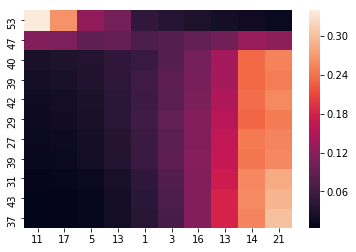

In [229]:
import seaborn as sns
ax = sns.heatmap(attention_density,   
        xticklabels=[w for w in test_input],
        yticklabels=[w for w in predictions])
ax.invert_yaxis()

# Reference

- https://guillaumegenthial.github.io/sequence-to-sequence.html
- https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html